In [107]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


from mpl_toolkits.axes_grid1 import make_axes_locatable
from SNN.models import SNNLayer
from SNN.utils import temporal_encode

In [108]:
device = torch.device("cuda")

In [109]:
labels = ['bend', 'jack', 'jump', 'pjump', 'run', 'side', 'skip', 'walk', 'wave1', 'wave2']

In [110]:
data_dict = np.load("data\weizmann_dataset\processed_data\dataset.npz")
combined_data = []
combined_labels = []

# Loop through the dictionary to combine data and labels
for label, data_array in data_dict.items():
    # Append the data array entries to all_data
    combined_data.append(data_array)  # Keeps the (num_entries, 4, width, height) shape
    
    # Create a list of labels for each entry in this data_array and extend all_labels
    combined_labels.extend([label] * data_array.shape[0])

del(data_array)
# Concatenate all data along the first axis to create a single numpy array
combined_data = np.concatenate(combined_data, axis=0)  # Shape: (total_entries, 4, width, height)
combined_labels = np.array(combined_labels)             # Shape: (total_entries,)


# Convert each label in combined_labels to its corresponding index
label_indices = [labels.index(label) for label in combined_labels]

# Create a one-hot encoded array using np.eye
num_classes = len(labels)
one_hot_labels = np.eye(num_classes)[label_indices]  # Shape: (total_entries, num_classes)


number_of_devices = 15 * 25 // 1


indices = np.random.permutation(combined_data.shape[0])
shuffled_data = combined_data[indices]
shuffled_labels = one_hot_labels[indices]
del(combined_data, combined_labels, one_hot_labels, data_dict, label_indices)

print("Combined data shape:", shuffled_data.shape)
print("Combined labels shape:", shuffled_labels.shape)

Combined data shape: (503, 4, 15, 25)
Combined labels shape: (503, 10)


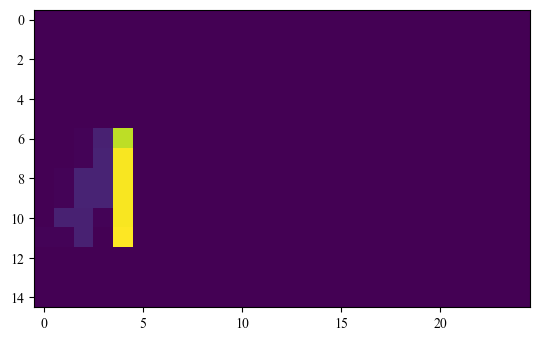

In [111]:
imgs = shuffled_data[100]/255

plt.imshow(
    (
        imgs[0]*1000+
        imgs[1]*100+
        imgs[2]*10+
        imgs[3]
    )
)

In [112]:
# Define the split ratios
train_ratio = 0.85
val_ratio = 0.0
test_ratio = 0.15

# Total number of entries
total_entries = shuffled_data.shape[0]

# Calculate split indices
train_end = int(total_entries * train_ratio)
val_end = train_end + int(total_entries * val_ratio)

# Split the data and labels
train_data = shuffled_data[:train_end]
train_labels = shuffled_labels[:train_end]

val_data = shuffled_data[train_end:val_end]
val_labels = shuffled_labels[train_end:val_end]

test_data = shuffled_data[val_end:]
test_labels = shuffled_labels[val_end:]

# Print shapes to verify
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_data.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)


Train data shape: (427, 4, 15, 25)
Train labels shape: (427, 10)
Validation data shape: (0, 4, 15, 25)
Validation labels shape: (0, 10)
Test data shape: (76, 4, 15, 25)
Test labels shape: (76, 10)


In [113]:
# reservoir_states = pd.read_excel("./data/reservoir_yasir_v2.xlsx")
reservoir_states = pd.read_excel("./data/mos2_reservoir_states.xlsx")
reservoir_states['drain current'].to_dict()

{0: 7e-09,
 1: 9.494e-06,
 2: 9.8e-08,
 3: 1.1605e-05,
 4: 5.2e-08,
 5: 1.3354e-05,
 6: 1.66e-07,
 7: 1.8095e-05,
 8: 3.8e-08,
 9: 1.8297e-05,
 10: 1.17e-07,
 11: 1.6929e-05,
 12: 6e-08,
 13: 2.1097e-05,
 14: 1.41e-07,
 15: 2.3166e-05}

In [114]:
# class CustomDataset(Dataset):
#     def __init__(self, data, labels, reservoir_states, number_of_devices=196):
#         super().__init__()
#         self.processed_data = []
#         self.labels = []



#         data = data.reshape((data.shape[0], 4, number_of_devices)) /255
#         data = (
#             data[:, 0, :]*8+
#             data[:, 1, :]*4+
#             data[:, 2, :]*2+
#             data[:, 3, :]
#         )

#         mapping_dict = reservoir_states['drain current'].to_dict()

#         self.processed_data = torch.tensor(np.vectorize(mapping_dict.get)(data)).to(device) / reservoir_states['drain current'].to_numpy().max()
#         self.labels = torch.tensor(labels).argmax(dim=1).to(device)

#     def __len__(self):
#         return self.processed_data.shape[0]
    
#     def __getitem__(self, index):
#         return self.processed_data[index], self.labels[index]
    
class CustomDataset(Dataset):
    def __init__(self, data, labels, reservoir_states, number_of_devices=196, d2d_variations=0.10):
        super().__init__()
        self.processed_data = []
        self.labels = []
        
        assert (d2d_variations >=0 and d2d_variations<1)



        data = data.reshape((data.shape[0], 4, number_of_devices)) /255
        data = torch.tensor((
            data[:, 0, :]*8+
            data[:, 1, :]*4+
            data[:, 2, :]*2+
            data[:, 3, :]
        )).long()
        B, N= data.shape
        M = len(reservoir_states)

        data = F.one_hot(data, M)

        # print(f"Data shape = {data.shape}")

        # conductance_tensor = torch.tensor(reservoir_states['drain current'].to_numpy()).view(( 1, M)).expand((N, M))
        conductance_tensor = torch.tensor(reservoir_states['drain current'].to_numpy()).view((1, M)).repeat((N, 1))

        
        # Randomly select x% of N rows
        num_rows = int(d2d_variations * N)
        row_indices = torch.randperm(N)[:num_rows]  # (num_rows,)
        
        mask = self.get_mask(row_indices, N, M, 8)

        conductance_tensor[mask] = reservoir_states['drain current'].to_numpy()[0]
        # conductance_tensor[mask] = 14e-9

        self.processed_data = (data * conductance_tensor).sum(dim=2).to(device) *1e7 # shape (B, N)




        # mapping_dict = reservoir_states['drain current'].to_dict()

        # self.processed_data = torch.tensor(np.vectorize(mapping_dict.get)(data)).to(device) * 1e7
        self.labels = torch.tensor(labels).argmax(dim=1).to(device)

    def get_mask(self, indices, N, M, m):
        result = torch.zeros((N, M), dtype=torch.bool)

        # For each row, randomly choose `m` indices to set to True
        idx = torch.rand((N, M)).argsort(dim=1)[:, :m]  # Get indices of top `m` random values per row
        row_indices = torch.arange(N).unsqueeze(1).expand(-1, m)

        result[row_indices, idx] = True

        second_mask = torch.zeros((N, M), dtype=bool)
        second_mask[indices] = True

        return result*second_mask
    
    def __len__(self):
        return self.processed_data.shape[0]
    
    def __getitem__(self, index):
        return self.processed_data[index], self.labels[index]

ds = CustomDataset(train_data, train_labels, reservoir_states, 15*25 // 1)



In [115]:

BATCH_SIZE = 1024


train_dataset = CustomDataset(train_data, train_labels, reservoir_states, number_of_devices)
test_dataset = CustomDataset(test_data, test_labels, reservoir_states, number_of_devices)


train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)



In [116]:
# img = train_dataset[0][0].reshape((25, 15)).cpu()

# plt.imshow(img)

In [117]:

BATCH_SIZE = 254

class ResourceRichReadoutLayer(nn.Module):
    def __init__(self, input_size: int):
        super(ResourceRichReadoutLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch Norm after first FC layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout with 30% probability

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  # Batch Norm after second FC layer
        self.dropout2 = nn.Dropout(0.3)  # Dropout

        self.fc3 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        self.act = F.gelu

    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)  # Output layer (logits)
        return x


class ResourceConstraintedReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ResourceConstraintedReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, 10)
        self.activation = nn.functional.leaky_relu
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.fc(x))
        return x
    

In [118]:

EPOCHS = 2000
learning_rate = 0.0005
# learning_rate = 1e-3

# model = ResourceConstraintedReadoutLayer(number_of_devices).to(device=device)
model = ResourceRichReadoutLayer(number_of_devices).to(device=device)
# model = SNN(number_of_devices * NUMBER_OF_MASKS, num_classes=10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
precision = Precision(task="multiclass", num_classes=10, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=10, average='macro').to(device)
f1_score = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=10).to(device)


In [119]:
print(len(labels))

10


In [120]:
for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        # spike_train = temporal_encode(images)
        outputs = model(images.float())  # Forward pass
        # outputs = model(spike_train)
        loss = criterion(outputs, labels)  # Loss calculation
        optimizer.zero_grad()
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    
    # Validation phase
    # model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images, labels
            # spike_train = temporal_encode(images)
            outputs = model(images.float())
            # outputs = model(spike_train)
            preds = outputs.argmax(dim=1)

            # Update metrics
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

        # Print validation metrics

        if (epoch+1)%10 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}', end=" ")
            print(f'Validation - Accuracy: {accuracy.compute().item():.4f} Precision: {precision.compute().item():.4f} ', end=" ")
            print(f'Recall: {recall.compute().item():.4f} F1 Score: {f1_score.compute().item():.4f}')

        # Updating the list to save current metrics
            val_accuracy.append(accuracy.compute().item())
            val_precision.append(precision.compute().item())
            val_recall.append(recall.compute().item())
            val_fscore.append(f1_score.compute().item())

        # Reset metrics for the next epoch
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()
        confusion_matrix.reset()

Epoch [10/2000], Loss: 2.0622 Validation - Accuracy: 0.2927 Precision: 0.3214  Recall: 0.2645 F1 Score: 0.2549
Epoch [20/2000], Loss: 1.8566 Validation - Accuracy: 0.3981 Precision: 0.4057  Recall: 0.3704 F1 Score: 0.3757
Epoch [30/2000], Loss: 1.6982 Validation - Accuracy: 0.4778 Precision: 0.4607  Recall: 0.4402 F1 Score: 0.4407
Epoch [40/2000], Loss: 1.5437 Validation - Accuracy: 0.5621 Precision: 0.5314  Recall: 0.5253 F1 Score: 0.5221
Epoch [50/2000], Loss: 1.4309 Validation - Accuracy: 0.6253 Precision: 0.6111  Recall: 0.5879 F1 Score: 0.5874
Epoch [60/2000], Loss: 1.2782 Validation - Accuracy: 0.6347 Precision: 0.6088  Recall: 0.5965 F1 Score: 0.5902
Epoch [70/2000], Loss: 1.2135 Validation - Accuracy: 0.6768 Precision: 0.6339  Recall: 0.6359 F1 Score: 0.6240
Epoch [80/2000], Loss: 1.1191 Validation - Accuracy: 0.6932 Precision: 0.6750  Recall: 0.6564 F1 Score: 0.6568
Epoch [90/2000], Loss: 1.0288 Validation - Accuracy: 0.7494 Precision: 0.7395  Recall: 0.7125 F1 Score: 0.7120
E

In [121]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        # spike_train = temporal_encode(images)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        # outputs = model(spike_train)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels
all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)

# Calculate metrics
test_accuracy = accuracy(all_preds, all_labels)
test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy * 100:.4f}%')
print(f'Test Precision: {test_precision*100:.4f}%')
print(f'Test Recall: {test_recall*100:.4f}%')
print(f'Test F1 Score: {test_f1:.4f}')

        

Test Accuracy: 99.2974%
Test Precision: 99.4445%
Test Recall: 99.3617%
Test F1 Score: 0.9938


C:\Users\adith\AppData\Local\Temp\ipykernel_6148\3293541747.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


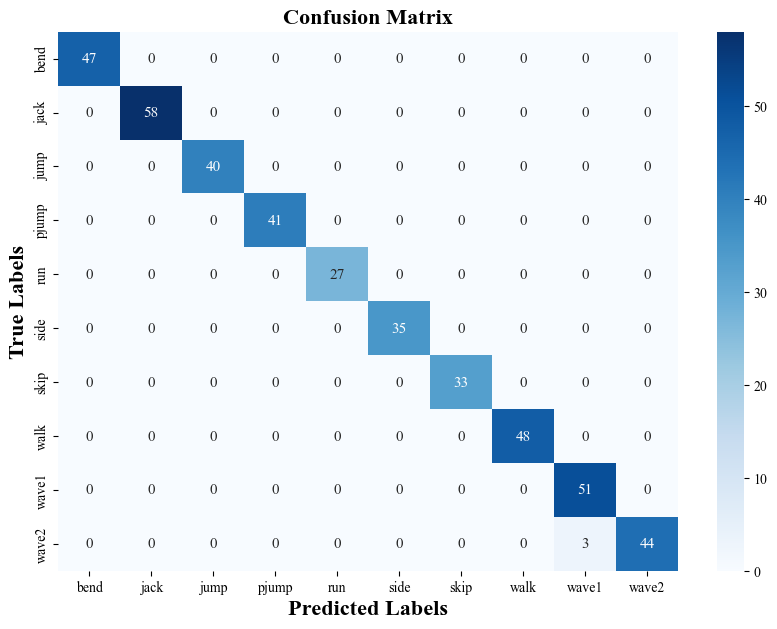

In [122]:
import seaborn as sns
plt.rcParams["font.family"] = "Times New Roman"
class_names = ['bend', 'jack', 'jump', 'pjump', 'run', 'side', 'skip', 'walk', 'wave1', 'wave2']
plt.figure(figsize=(10, 7))
sns.heatmap(test_confusion_matrix.cpu(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            annot_kws={"size": 11, "family": "Times New Roman"})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=16, fontweight='bold')
plt.ylabel('True Labels', fontsize=16, fontweight='bold')
plt.show()

In [123]:
x = np.argmax(val_fscore)
print(f"Accuracy = {val_accuracy[x]:.5f}\nPrecision = {val_precision[x]:.5f}\nRecall = {val_recall[x]:.5f}\nF-score = {val_fscore[x]:.5f}")
# print(val_accuracy[x], val_precision[x], val_recall[x], val_fscore[x])

Accuracy = 0.99063
Precision = 0.99240
Recall = 0.99118
F-score = 0.99158


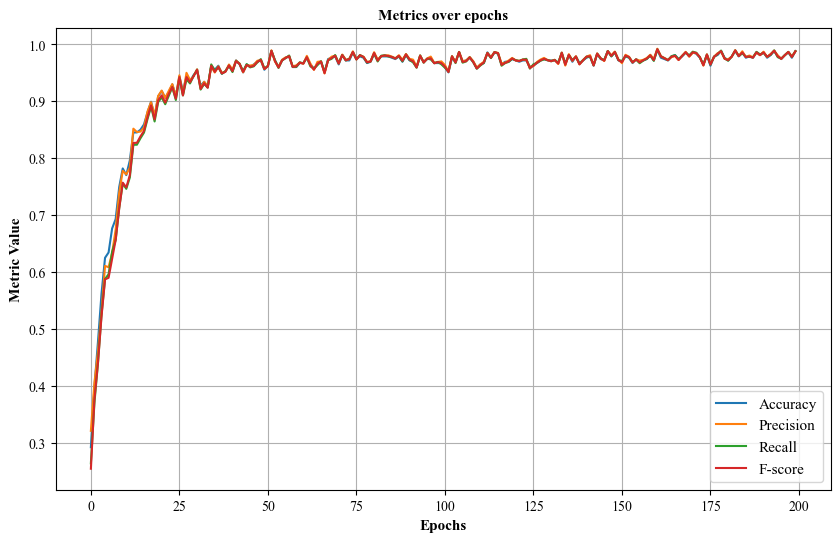

In [124]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

plt.plot([i for i in range(len(val_accuracy))], val_accuracy, label='Accuracy')
plt.plot([i for i in range(len(val_precision))], val_precision, label='Precision')
plt.plot([i for i in range(len(val_recall))], val_recall, label='Recall')
plt.plot([i for i in range(len(val_fscore))], val_fscore, label='F-score')



# Add title, labels, and legend
plt.title('Metrics over epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel('Metric Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()

In [125]:
if isinstance(model, ResourceRichReadoutLayer):
    model_type = "no_resource_constraint"
elif isinstance(model, ResourceConstraintedReadoutLayer):
    model_type = "resource_constraint"
else:
    raise TypeError("ARMAGEDDON HERE IN MODEL TYPE")


metrics_path = f"data/RC_yasir_metrics_v2/weizmann_dataset/RC_{model_type}/"

metrics_path = f"data/MOS2_Results_V2/d2d_10/weizmann_dataset/"


print(metrics_path)

data/MOS2_Results_V2/d2d_10/weizmann_dataset/


In [126]:
metrics_df = pd.DataFrame({
    "Accuracy":val_accuracy,
    "Precision":val_precision,
    "Recall":val_recall,
    "F-Score":val_fscore
})


In [127]:

confusion_matrix_df = pd.DataFrame(test_confusion_matrix.cpu().numpy(), index=class_names, columns=class_names)

# metrics_path = "./data/MOS2_metrics/Weizmann_dataset/"
# confusion_matrix_df


In [129]:

metrics_df.to_excel(metrics_path + "metrics.xlsx")
confusion_matrix_df.to_excel(metrics_path + "confusion_matrix.xlsx")